# 05_02_CNN_CIFAR10
对于视觉数据，PyTorch 创建了一个叫做 totchvision 的包，该包含有支持加载类似Imagenet，CIFAR10，MNIST 等公共数据集的数据加载模块 torchvision.datasets 和支持加载图像数据数据转换模块 torch.utils.data.DataLoader。

下面将使用CIFAR10数据集，它包含十个类别：‘airplane’, ‘automobile’, ‘bird’, ‘cat’, ‘deer’, ‘dog’, ‘frog’, ‘horse’, ‘ship’, ‘truck’。CIFAR-10 中的图像尺寸为3x32x32，也就是RGB的3层颜色通道，每层通道内的尺寸为32*32。


首先，加载并归一化 CIFAR10 使用 torchvision 。torchvision 数据集的输出是范围在[0,1]之间的 PILImage，我们将他们转换成归一化范围为[-1,1]之间的张量 Tensors。

大家肯定好奇，下面代码中说的是 0.5，怎么就变化到[-1,1]之间了？PyTorch源码中是这么写的：

``input[channel] = (input[channel] - mean[channel]) / std[channel]``

这样就是：（0,1）-0.5）/0.5=(-1,1)。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# 使用GPU训练，可以在菜单 "代码执行工具" -> "更改运行时类型" 里进行设置
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# 注意下面代码中：训练的 shuffle 是 True，测试的 shuffle 是 false
# 训练时可以打乱顺序增加多样性，测试是没有必要
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:59<00:00, 2856210.67it/s]


Extracting ./data\cifar-10-python.tar.gz to ./data
Files already downloaded and verified


下面展示 CIFAR10 里面的一些图片：

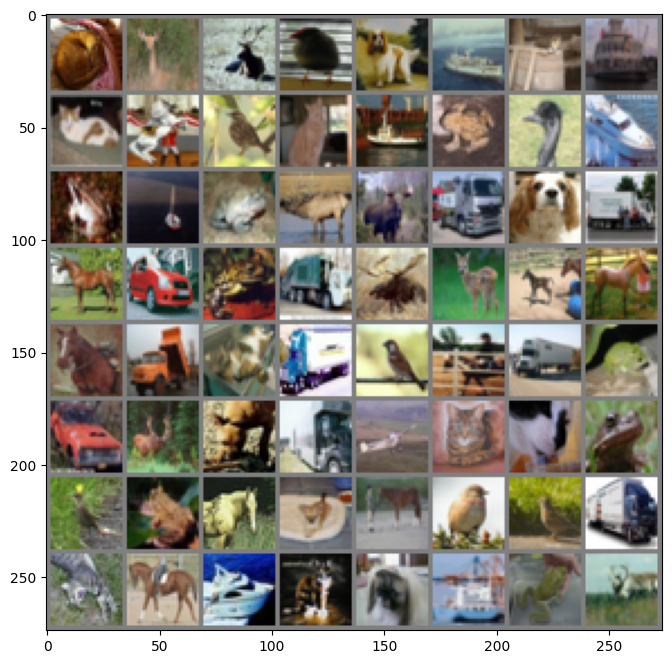

cat
deer
deer
bird
dog
ship
cat
ship


In [ ]:
def imshow(img):
    plt.figure(figsize=(8,8))
    img = img / 2 + 0.5     # 转换到 [0,1] 之间
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 得到一组图像
images, labels = next(iter(trainloader))
# 展示图像
imshow(torchvision.utils.make_grid(images))
# 展示第一行图像的标签
for j in range(8):
    print(classes[labels[j]])

接下来定义网络，损失函数和优化器：

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# 网络放到GPU上
net = Net().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

训练网络：

In [5]:
for epoch in range(10):  # 重复多轮训练
    for i, (inputs, labels) in enumerate(trainloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        # 优化器梯度归零
        optimizer.zero_grad()
        # 正向传播 +　反向传播 + 优化 
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # 输出统计信息
        if i % 100 == 0:   
            print('Epoch: %d Minibatch: %5d loss: %.3f' %(epoch + 1, i + 1, loss.item()))

print('Finished Training')

Epoch: 1 Minibatch:     1 loss: 2.292
Epoch: 1 Minibatch:   101 loss: 1.942
Epoch: 1 Minibatch:   201 loss: 1.867
Epoch: 1 Minibatch:   301 loss: 1.705
Epoch: 1 Minibatch:   401 loss: 1.655
Epoch: 1 Minibatch:   501 loss: 1.441
Epoch: 1 Minibatch:   601 loss: 1.555
Epoch: 1 Minibatch:   701 loss: 1.560
Epoch: 2 Minibatch:     1 loss: 1.294
Epoch: 2 Minibatch:   101 loss: 1.471
Epoch: 2 Minibatch:   201 loss: 1.567
Epoch: 2 Minibatch:   301 loss: 1.351
Epoch: 2 Minibatch:   401 loss: 1.292
Epoch: 2 Minibatch:   501 loss: 1.452
Epoch: 2 Minibatch:   601 loss: 1.348
Epoch: 2 Minibatch:   701 loss: 1.462
Epoch: 3 Minibatch:     1 loss: 1.536
Epoch: 3 Minibatch:   101 loss: 1.195
Epoch: 3 Minibatch:   201 loss: 1.477
Epoch: 3 Minibatch:   301 loss: 1.083
Epoch: 3 Minibatch:   401 loss: 1.075
Epoch: 3 Minibatch:   501 loss: 1.137
Epoch: 3 Minibatch:   601 loss: 1.300
Epoch: 3 Minibatch:   701 loss: 1.167
Epoch: 4 Minibatch:     1 loss: 1.593
Epoch: 4 Minibatch:   101 loss: 0.987
Epoch: 4 Min

现在我们从测试集中取出8张图片：

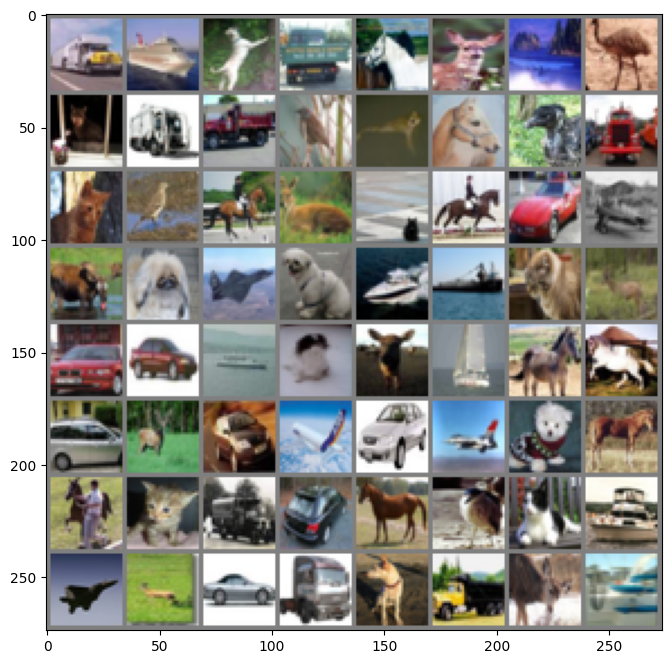

truck
ship
dog
truck
horse
deer
plane
bird


In [7]:
# 得到一组图像
images, labels = next(iter(trainloader))
# 展示图像
imshow(torchvision.utils.make_grid(images))
# 展示图像的标签
for j in range(8):
    print(classes[labels[j]])

我们把图片输入模型，看看CNN把这些图片识别成什么：

In [8]:
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

# 展示预测的结果
for j in range(8):
    print(classes[predicted[j]])

truck
ship
deer
ship
horse
dog
plane
deer


可以看到，有几个都识别错了~~~ 让我们看看网络在整个数据集上的表现：

In [9]:
correct = 0
total = 0

for data in testloader:
    images, labels = data
    images, labels = images.to(device), labels.to(device)
    outputs = net(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


准确率还可以，通过改进网络结构，性能还可以进一步提升。在 Kaggle 的LeaderBoard上，准确率高的达到95%以上。

感兴趣的同学可以看看别人的解决方案，思考如何提升分类性能。